In [1]:
using Turing
using ForwardDiff
using LimberJack
using CSV
using NPZ
using FITSIO
using Plots
using LinearAlgebra
using Distributed

┌ Info: Precompiling LimberJack [6b86205d-155a-4b14-b82d-b6a149ea78f2]
└ @ Base loading.jl:1423


In [2]:
# Add four processes to use for sampling.
#addprocs(4)

# Initialize everything on all the processes.
# Note: Make sure to do this after you've already loaded Turing,
#       so each process does not have to precompile.
#       Parallel sampling may fail silently if you do not do this.
#@everywhere using Turing, LimberJack

In [3]:
des_nzs = FITS("../data/DESY1_cls/y1_redshift_distributions_v1.fits")
des_nz2 = read(des_nzs["nz_source_mcal"], "BIN2")
des_nz3 = read(des_nzs["nz_source_mcal"], "BIN3")
des_zs = read(des_nzs["nz_source_mcal"], "Z_MID");
ell = npzread("../data/DESY1_cls/DESgc_DESwl/cl_DESgc__2_DESwl__3.npz")["ell"]
ell = [Int(floor(l)) for l in ell];

In [4]:
cl_path1 = "../data/DESY1_cls/DESgc_DESgc/"
cl_path2 = "../data/DESY1_cls/DESgc_DESwl/"
cl_path3 = "../data/DESY1_cls/DESwl_DESwl/"
cov_path = "../data/DESY1_cls/covs/"
datas = [Data("DESgc", "DESgc", 2, 2, cl_path=cl_path1, cov_path=cov_path),
         Data("DESgc", "DESgc", 3, 3, cl_path=cl_path1, cov_path=cov_path),
         Data("DESgc", "DESwl", 2, 3, cl_path=cl_path2, cov_path=cov_path)]; 
Cls_metas = Cls_meta(datas, covs_path=cov_path);
cov_tot = Cls_metas.cov_tot;
data_vector = Cls_metas.data_vector;

["DESgc__2_DESgc__2_DESgc__2_DESgc__2", "DESgc__2_DESgc__2_DESgc__3_DESgc__3", "DESgc__2_DESgc__2_DESgc__2_DESwl__3", "DESgc__3_DESgc__3_DESgc__3_DESgc__3", "DESgc__3_DESgc__3_DESgc__2_DESwl__3", "DESgc__2_DESwl__3_DESgc__2_DESwl__3"]
Found cov file for: cov_DESgc__2_DESgc__2_DESgc__2_DESgc__2.npz
Found cov file for: cov_DESgc__2_DESgc__2_DESgc__3_DESgc__3.npz
Found cov file for: cov_DESgc__2_DESgc__2_DESgc__2_DESwl__3.npz
Found cov file for: cov_DESgc__3_DESgc__3_DESgc__3_DESgc__3.npz
Seeting cov_DESgc__3_DESgc__3_DESgc__2_DESwl__3.npz to zeros
Found cov file for: cov_DESgc__2_DESwl__3_DESgc__2_DESwl__3.npz


In [5]:
isposdef(cov_tot)

true

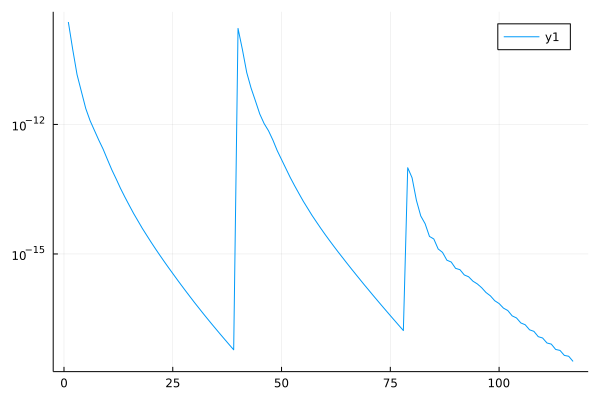

In [6]:
plot(diag(cov_tot), yaxis=:log)

In [ ]:
@model function model(data)
    Ωm ~ Uniform(0.2, 0.3)
    h ~ Uniform(0.6, 0.8)
    s8 ~ Uniform(0.7, 1.0)
    cosmology = LimberJack.Cosmology(Ωm, 0.05, h, 0.96, s8,
                                     tk_mode="EisHu",
                                     Pk_mode="Halofit")
    tg2 = NumberCountsTracer(cosmology, des_zs, des_nz2, 2.)
    tg3 = NumberCountsTracer(cosmology, des_zs, des_nz3, 2.)
    ts3 = WeakLensingTracer(cosmology, des_zs, des_nz3)
    g2g2 = [angularCℓ(cosmology, tg2, tg2, ℓ) for ℓ in ell]
    #g2g3 = [angularCℓ(cosmology, tg2, tg3, ℓ) for ℓ in ell]
    g3g3 = [angularCℓ(cosmology, tg3, tg3, ℓ) for ℓ in ell]
    g2s3 = [angularCℓ(cosmology, tg2, ts3, ℓ) for ℓ in ell]
    predictions = [g2g2, g3g3, g2s3]
    predictions = vcat(predictions...)
    data ~ MvNormal(predictions, cov_tot)
end;

iterations = 500
step_size = 0.005
samples_per_step = 10
cores = 4

# Start sampling.
folpath = "../chains"
folname = string("DES_combined_test_", "stpsz_", step_size, "_smpls_", samples_per_step)
folname = joinpath(folpath, folname)
if isdir(folname)
    println("Folder already exists")
    if isfile(joinpath(folname, "chain.jls"))
        println("Restarting from past chain")
        past_chain = read(joinpath(folname, "chain.jls"), Chains)
        new_chain = sample(model(data_vector), HMC(step_size, samples_per_step), iterations,
                           progress=true; save_state=true, resume_from=past_chain)
    else
        new_chain = sample(model(data_vector), HMC(step_size, samples_per_step),
                    iterations, progress=true; save_state=true)
    end
else
    mkdir(folname)
    println("Created new folder")
    new_chain = sample(model(data_vector), HMC(step_size, samples_per_step),
                iterations, progress=true; save_state=true)
end

info = describe(new_chain)[1]
fname_info = string("info.csv")
CSV.write(joinpath(folname, fname_info), info)


fname_jls = string("chain.jls")
write(joinpath(folname, fname_jls), new_chain)
    
fname_csv = string("chain.csv")
CSV.write(joinpath(folname, fname_csv), new_chain)


Sampling:   8%|███▏                                     |  ETA: 1:26:39